In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

from models.macaw import MACAW

import sys

sys.path.append("..")

from utils.datasets import TorchDataset as TD
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mode = "test"
test_block = "flat"
nlatents = 64
ncauses = 19
sex_idx = 9
PD_idx = 18

In [ ]:
model = MACAW(nlatents=nlatents).to("cuda")
checkpoint = torch.load(f"checkpoints/act-macaw-{test_block}/best_model.pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [4]:
ds = TD(f"/data/Data/PD/activations_{test_block}_{mode}")
data_loader = DataLoader(ds, batch_size=128, shuffle=False)

In [5]:
import numpy as np

g_dict = {"Study": np.arange(9), "Sex": [0, 1]}
cf_dict = {}


temp = {k: 0 for k in range(9)}
model.eval()

grp_mean = np.zeros((len(ds), nlatents + ncauses))
for v in range(9):
    obs = []
    cfs = []
    cf_vals = temp.copy()
    cf_vals[v] = 1
    for b in data_loader:
        x_obs, x_cf = model.counterfactuals(b.to("cuda"), cf_vals=cf_vals)
        obs.append(x_obs)
        cfs.append(x_cf)

    obs = np.vstack(obs)
    cf = np.vstack(cfs)
    grp_mean += cf

    cf_dict[f"Study_{v}"] = cf

cf_dict[f"Study_mean"] = grp_mean / 9

grp_mean = np.zeros((len(ds), nlatents + ncauses))
for v in [0, 1]:
    obs = []
    cfs = []
    for b in data_loader:
        x_obs, x_cf = model.counterfactuals(b.to("cuda"), cf_vals={sex_idx: v})
        obs.append(x_obs)
        cfs.append(x_cf)

    obs = np.vstack(obs)
    cf = np.vstack(cfs)
    grp_mean += cf

    cf_dict[f"Sex_{v}"] = cf

cf_dict[f"Sex_mean"] = grp_mean / 2


In [14]:
obs_study = np.argmax(obs[:, 0:9], axis=1)
obs_sex = obs[:, sex_idx]
obs_pd = obs[:, PD_idx]
obs_act = obs[:, ncauses:]
cf_study_act = cf_dict["Study_mean"][:, ncauses:]
cf_sex_act = cf_dict["Sex_mean"][:, ncauses:]

## PCA analyses

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=nlatents)
pca_obs = pca.fit_transform(obs_act)
pca_cf_study = pca.transform(cf_study_act)
pca_cf_sex = pca.transform(cf_sex_act)

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns


def comparison_plot(
    pca_0, pca_1, cf_pca_0, cf_pca_1, col, name, cat=None, savename="pca"
):
    fig = plt.figure(figsize=(9, 4))
    gs = fig.add_gridspec(4, 9, wspace=0, hspace=0)

    # Create the scatter plot and marginal axes
    ax_scatter_obs = fig.add_subplot(gs[1:, :3])
    ax_histx_obs = fig.add_subplot(gs[0, :3], sharex=ax_scatter_obs)
    ax_histy_obs = fig.add_subplot(gs[1:, 3], sharey=ax_scatter_obs)

    ax_scatter_cf = fig.add_subplot(gs[1:, 5:-1])
    ax_histx_cf = fig.add_subplot(gs[0, 5:-1], sharex=ax_scatter_cf)
    ax_histy_cf = fig.add_subplot(gs[1:, -1], sharey=ax_scatter_cf)

    mask = []
    if cat is None:
        cat = np.unique(col)

    for category in cat:
        mask.append(col == category)

    mask = np.bitwise_or.reduce(mask, axis=0)

    pca_0 = pca_0[mask]
    pca_1 = pca_1[mask]

    cf_pca_0 = cf_pca_0[mask]
    cf_pca_1 = cf_pca_1[mask]
    col = col[mask]

    sns.scatterplot(
        x=pca_0,
        y=pca_1,
        hue=col,
        palette="deep",
        alpha=0.6,
        ax=ax_scatter_obs,
        legend=False,
    )

    # sns.move_legend(
    #     ax_scatter_obs,
    #     "lower left",
    #     mode="expand",
    #     markerscale=0.5,
    #     # bbox_to_anchor=(0.5, 1),
    #     fontsize=7,
    #     ncol=5,
    #     title=None,
    #     labelspacing=0.01,
    #     frameon=False,
    # )

    # plt.setp(ax_scatter_obs.get_legend().get_texts(), fontsize="8")  # for legend text

    sns.scatterplot(
        x=cf_pca_0,
        y=cf_pca_1,
        hue=col,
        palette="deep",
        alpha=0.6,
        ax=ax_scatter_cf,
        legend=False,
    )

    palette = sns.color_palette("deep", 15)
    for category, color in zip(cat, palette[: len(cat)]):
        mask = col == category
        sns.kdeplot(
            x=pca_0[mask],
            ax=ax_histx_obs,
            color=color,
            fill=True,
            alpha=0.5,
            label=category,
        )
        sns.kdeplot(
            y=pca_1[mask],
            ax=ax_histy_obs,
            color=color,
            fill=True,
            alpha=0.5,
            label=category,
        )
        sns.kdeplot(
            x=cf_pca_0[mask],
            ax=ax_histx_cf,
            color=color,
            fill=True,
            alpha=0.5,
            label=category,
        )
        sns.kdeplot(
            y=cf_pca_1[mask],
            ax=ax_histy_cf,
            color=color,
            fill=True,
            alpha=0.5,
            label=category,
        )

    ax_histx_obs.set_ylabel("")
    ax_histx_obs.set_title(name)
    ax_histy_obs.set_xlabel("")

    ax_scatter_obs.set_xlabel(f"PCA Mode 0")
    ax_scatter_obs.set_ylabel(f"PCA Mode 1")

    ax_scatter_obs.set_xticks([])
    ax_scatter_obs.set_yticks([])

    ax_histx_obs.grid(False)
    ax_histy_obs.grid(False)

    ax_histx_obs.set_xticks([])
    ax_histx_obs.set_yticks([])

    ax_histy_obs.set_xticks([])
    ax_histy_obs.set_yticks([])

    ax_histx_cf.set_ylabel("")
    ax_histx_cf.set_title(f"After removing {name} attribute")
    ax_histy_cf.set_xlabel("")

    ax_scatter_cf.set_xlabel(f"PCA Mode 0")
    ax_scatter_cf.set_ylabel(f"PCA Mode 1")

    ax_scatter_cf.set_xticks([])
    ax_scatter_cf.set_yticks([])

    ax_histx_cf.grid(False)
    ax_histy_cf.grid(False)

    ax_histx_cf.set_xticks([])
    ax_histx_cf.set_yticks([])

    ax_histy_cf.set_xticks([])
    ax_histy_cf.set_yticks([])

    plt.tight_layout()

    plt.savefig(f"/data/Papers/MICCAI-biases/macaw-analysis/{savename}.pdf", dpi=300)
    plt.show()

    return fig

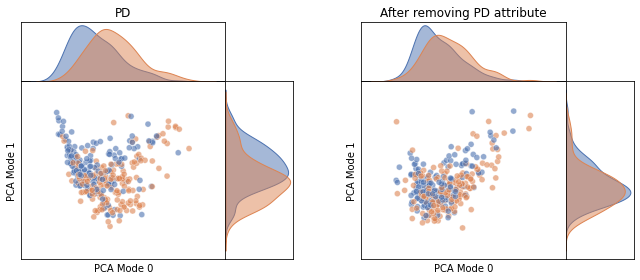

In [184]:
fig = comparison_plot(
    pca_obs[:, 0],
    pca_obs[:, 1],
    pca_cf_study[:, 0],
    pca_cf_study[:, 1],
    col=obs_pd,
    name="PD",
    savename="PD_study_pca01",
)

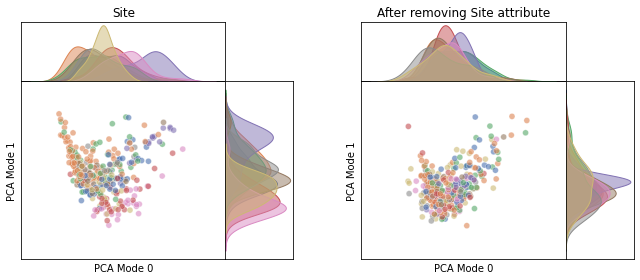

In [ ]:
fig = comparison_plot(
    pca_obs[:, 0],
    pca_obs[:, 1],
    pca_cf_study[:, 0],
    pca_cf_study[:, 1],
    col=obs_study,
    name="Site",
    savename="Site_pca01",
)


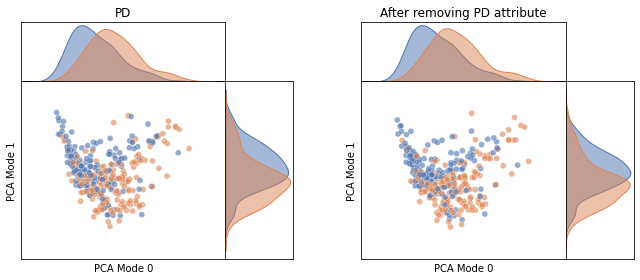

In [185]:
fig = comparison_plot(
    pca_obs[:, 0],
    pca_obs[:, 1],
    pca_cf_sex[:, 0],
    pca_cf_sex[:, 1],
    obs_pd,
    "PD",
    savename="PD_Sex_pca0",
)

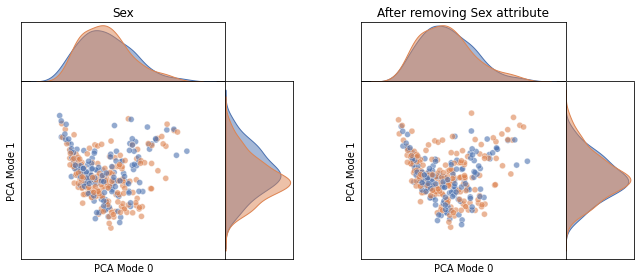

In [ ]:
fig = comparison_plot(
    pca_obs[:, 0],
    pca_obs[:, 1],
    pca_cf_sex[:, 0],
    pca_cf_sex[:, 1],
    obs_sex,
    "Sex",
    savename="Sex_pca0",
)

## SPLIT analyses

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

from bias_registry import BiasRegistry
from models.sfcn_original import SFCN

import sys

sys.path.append("..")
from utils.datasets import TorchDataset as TD
from torch.utils.data import DataLoader

In [ ]:
@torch.no_grad()
def test(model, test_path, bias_idx, class_idx):
    batch_size = 8
    test_loader = DataLoader(TD(test_path), batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []

    for batch in tqdm(test_loader, desc="Test"):
        x = batch[0].to("cuda")
        y_true += 1 * (batch[bias_idx] == class_idx).cpu().tolist()
        y_pred += torch.sigmoid(model(x)).detach().cpu().tolist()

    return y_true, y_pred

In [ ]:
import matplotlib.pyplot as plt


def plot_auroc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    print("AUC: ", roc_auc)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)

    return roc_auc

In [162]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [167]:
from sklearn.metrics import roc_curve, auc

bias_idx = 3
class_idxs = np.arange(9)

aurocs_obs = []
aurocs_cf = []

for c in class_idxs:
    checkpoint = torch.load(f"checkpoints/study-SFCN-{bias_idx}-{c}/best_model.pt")
    weights = checkpoint["model_state_dict"]["classifier.fc.weight"].data.cpu().numpy()
    bias = checkpoint["model_state_dict"]["classifier.fc.bias"].data.cpu().numpy()

    y_true = 1 * (obs_study == c)

    y_pred = sigmoid(obs_act @ weights.T + bias).squeeze()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    aurocs_obs.append(auc(fpr, tpr))

    y_pred = sigmoid(cf_study_act @ weights.T + bias).squeeze()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    aurocs_cf.append(auc(fpr, tpr))


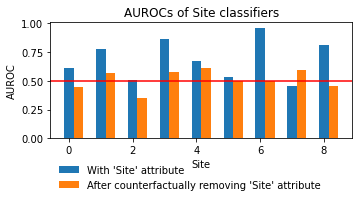

In [188]:
plt.figure(figsize=(5, 3))

ind = np.arange(9)
# Width of a bar
width = 0.3

# Plotting
plt.bar(ind, aurocs_obs, width, label="With 'Site' attribute")
plt.bar(
    ind + width,
    aurocs_cf,
    width,
    label="After counterfactually removing 'Site' attribute",
)
plt.axhline(y=0.5, color="r", linestyle="-")

plt.xlabel("Site")
plt.ylabel("AUROC")
plt.title("AUROCs of Site classifiers")

# Finding the best position for legends and putting it
plt.legend(loc="upper left", bbox_to_anchor=(0, -0.15), frameon=False, ncols=1)
plt.tight_layout()


plt.savefig("/data/Papers/MICCAI-biases/split/site.pdf")
plt.show()


In [165]:
aurocs_obs = []
aurocs_cf = []

checkpoint = torch.load(f"checkpoints/study-Sex-2-0/best_model.pt")
weights = checkpoint["model_state_dict"]["classifier.fc.weight"].data.cpu().numpy()
bias = checkpoint["model_state_dict"]["classifier.fc.bias"].data.cpu().numpy()

y_true = 1 * (obs_sex == 0)

y_pred = sigmoid(obs_act @ weights.T + bias).squeeze()
fpr, tpr, _ = roc_curve(y_true, y_pred)
aurocs_obs = auc(fpr, tpr)

y_pred = sigmoid(cf_sex_act @ weights.T + bias).squeeze()
fpr, tpr, _ = roc_curve(y_true, y_pred)
aurocs_cf = auc(fpr, tpr)

aurocs_obs, aurocs_cf

(0.6249954066071363, 0.47903575497005113)